# LN - Analysis - Decision impact

## Import Libraries

In [1]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from botocore.handlers import disable_signing
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import re
import io
import math
import copy
import sklearn
from tqdm.notebook import trange, tqdm
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Load Data

Load dataframe from AWS S3 bucket and save it into full_decisions_df.

In [10]:
s3 = boto3.resource('s3')
s3.meta.client.meta.events.register('choose-signer.s3.*',disable_signing)

bucket='ln-strategy-data'

decisions_load = s3.Object(bucket_name=bucket, key='full_decisions_df.csv').get()
decisions_df = pd.read_csv(io.BytesIO(decisions_load['Body'].read()))

In [11]:
decisions_df.head()

,Unnamed: 0,Unnamed: 0.1,short_channel_id,open_block,open_transaction,address,close_block,close_transaction,node0,node1,...,closeness_approx_rank_post_n0_close_norm_rankpost,closeness_approx_rank_post_n1_close_norm_rankpost,current_betweeness_unweighted_n0_open_norm_rank,current_betweeness_unweighted_n1_open_norm_rank,current_betweeness_unweighted_n0_close_norm_rank,current_betweeness_unweighted_n1_close_norm_rank,current_betweeness_unweighted_n0_open_norm_rankpost,current_betweeness_unweighted_n1_open_norm_rankpost,current_betweeness_unweighted_n0_close_norm_rankpost,current_betweeness_unweighted_n1_close_norm_rankpost
0,0,72475,617297x720x0,617297,5aa10236396e6f1118806e0725572e3681f750a39401d1...,bc1qxklh2cq63d4s9pn0lmv9n04k9ly7ndhny4d848d950...,NaN,NaN,029bf3edd752470fb554330e8d40f7f10d73e9f9838898...,02da8d5a759ee9e4438da617cfdb61c87f723fb76c4b63...,...,NaN,NaN,0.084238,0.026873,NaN,NaN,0.083861,0.014369,NaN,NaN
1,1,72473,617295x550x0,617295,3a52a4d6dc06418c9477d34c4ee834b46c6bd6e0a55b12...,bc1qc46akgl8s3le5g038n92ha90rm666u397gs6s5tmzh...,NaN,NaN,0237fefbe8626bf888de0cad8c73630e32746a22a2c4fa...,033edf115cbd38a6803d2912904c33d45df0d3c74a35dd...,...,NaN,NaN,0.060406,0.001278,NaN,NaN,0.018191,0.000531,NaN,NaN
2,2,72474,617295x1743x1,617295,0290e91d1007d8fb42c6a30c04af298337ea5e7833bc9e...,bc1qmadhqrsk77pgtpgt4k34hnjaysk290vfgsw2hua7p7...,NaN,NaN,028737303e12cb84643d1f0181812b559a56ef5d78b4c4...,03a503d8e30f2ff407096d235b5db63b4fcf3f89a653ac...,...,NaN,NaN,0.009378,0.115924,NaN,NaN,0.041591,0.171147,NaN,NaN
3,3,72472,617294x894x0,617294,801ef73a0e237275b81a625362b3173bcbea7aac0af280...,bc1q46yvjxf0dth8qwnlhzs00kczztgf38eh74eh6x5uec...,NaN,NaN,031567fdf33cb9b4ab081019199295ffce38218751842a...,033edf115cbd38a6803d2912904c33d45df0d3c74a35dd...,...,NaN,NaN,0.008583,0.000542,NaN,NaN,0.007532,0.001278,NaN,NaN
4,4,72470,617292x63x0,617292,557aaea396b8967031803fa8119fef9a17611229b7aea1...,bc1qw9vetekdv2kaw0gh4w5m60xdrwz968k7pwvw4fuzxy...,NaN,NaN,033edf115cbd38a6803d2912904c33d45df0d3c74a35dd...,03d37fca0656558de4fd86bbe490a38d84a46228e7ec13...,...,NaN,NaN,0.000364,0.192472,NaN,NaN,0.000542,0.168542,NaN,NaN


### Data Description

In [12]:
decisions_df.isnull().sum()

Unnamed: 0                                                  0
Unnamed: 0.1                                                0
short_channel_id                                            0
open_block                                                  0
open_transaction                                            0
address                                                     0
close_block                                             34121
close_transaction                                       34121
node0                                                       0
node1                                                       0
satoshis                                                    0
last_seen                                                   0
open_time                                                   0
open_fee                                                    0
close_time                                              34121
close_fee                                               34121
last_upd

### Node Distributions Dataframe

Data Cleaning and Transformations to extract features related to node properties at channel opening and closing.

In [7]:
# SCRIPT to create dataframe with feature values per node

features=['age','capacity_n','capacity_growth','channels','closeness','current_betweeness']
df_columns=list(full_decisions_df.columns)

# Create dictionary to store columns

df_dic={}

# Loop over features and Create DataFrame for each feature

for feature in features:

    # Extract columns that match feature reg_exp with block and node id
    feature_cols=[col for col in df_columns if (col.startswith(feature) and ('post' not in col))]
    array_list=[]
    
    for feature_col in feature_cols:
        
        
        if 'n0' in feature_col: # For node0 columns
        
            if 'open' in feature_col: # At open
                
                # Select block, node_id and feature col
                array_i=full_decisions_df[['open_block','node0_id',feature_col]].to_numpy()
                # Create array with 1s to represent that these are node status at open
                open_col=np.expand_dims(np.ones(len(array_i)), axis=1)
                # Add column with 1s
                array_i=np.concatenate((array_i,open_col),axis=1)
            
            elif 'close' in feature_col:
                
                # Select block, node_id and feature col
                array_i=full_decisions_df[['close_block','node0_id',feature_col]].to_numpy()
                # Create array with 1s to represent that these are node status at close
                close_col=np.expand_dims(np.zeros(len(array_i)), axis=1)
                # Add column with 1s
                array_i=np.concatenate((array_i,close_col),axis=1)
        
        elif 'n1' in feature_col: # For node1 columns
        
            if 'open' in feature_col: # At close
                
                # Select block, node_id and feature col
                array_i=full_decisions_df[['open_block','node1_id',feature_col]].to_numpy()
                # Create array with 1s to represent that these are node status at open
                open_col=np.expand_dims(np.ones(len(array_i)), axis=1)
                # Add column with 1s
                array_i=np.concatenate((array_i,open_col),axis=1)
            
            elif 'close' in feature_col:
                
                # Select block, node_id and feature col
                array_i=full_decisions_df[['close_block','node1_id',feature_col]].to_numpy()
                # Create array with 1s to represent that these are node status at close
                close_col=np.expand_dims(np.zeros(len(array_i)), axis=1)
                # Add column with 1s
                array_i=np.concatenate((array_i,close_col),axis=1)
                
            
        # Concatenate results vertically
        array_list.append(array_i)
        feature_rows=np.concatenate(array_list,axis=0)
        
    # Create DataFrame for feature
    df_dic[feature]=pd.DataFrame(feature_rows, columns = ['block', 'node',feature,'decision_type']) 
    
    
# Join Dictionaries into one

# Initate node dictionary
node_dic=list(df_dic.items())
df_list=[t[1] for t in node_dic]

node_feature_df=pd.concat(df_list,axis=1)
node_feature_df=node_feature_df.groupby(level=0, axis=1,).mean()
node_feature_df=node_feature_df.dropna()
node_feature_df.head()
    


,age,block,capacity_growth,capacity_n,channels,closeness,current_betweeness,decision_type,node
0,0.036720,617297.0,0.661339,0.106011,0.172872,0.983718,0.084238,1.0,5161.0
10,0.003344,617290.0,0.000448,0.000059,0.007092,0.705347,0.002170,1.0,994.0
11,0.000009,617289.0,0.000234,0.000031,0.001773,0.241699,0.000222,1.0,1260.0
12,0.380795,617289.0,0.000920,0.005139,0.014184,0.894494,0.003224,1.0,842.0
13,0.000232,617288.0,0.000123,0.000016,0.000887,0.583382,0.000000,1.0,2246.0


### K-means Clustering of Each Node Attribute to Extract Cut-off Points (with 3 Initialized Centroids)

In [18]:
from sklearn.cluster import KMeans

for i in range(len(features)):
    kmeans = KMeans(n_clusters=3, init=np.array([0, 0.3, 1]).reshape(-1,1), n_init=1)
    kmeans.fit(node_feature_df[features[i]].to_numpy().reshape(-1,1))
    
    node_feature_df[str(features[i]+'_cluster')] = kmeans.labels_

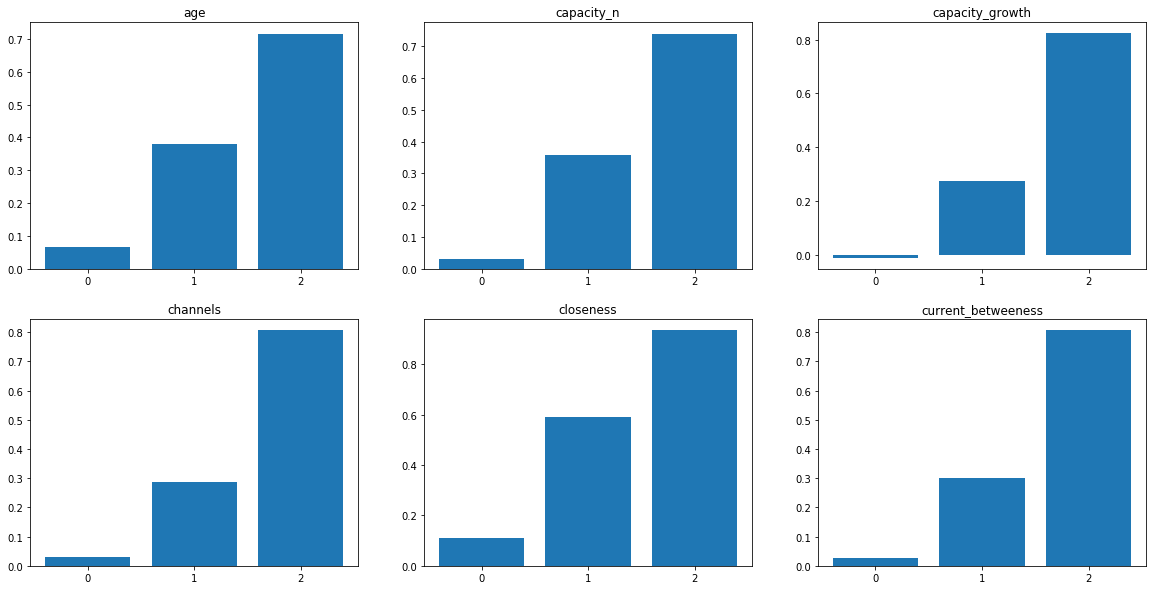

In [19]:
plt.figure(figsize=(20,10))

for i in range(len(features)):
    plt.subplot(2,3, i+1)
    plt.title(features[i])
    plt.xticks([0,1,2])
    groupby_obj = node_feature_df.groupby(str(features[i])+'_cluster')
    plt.bar(groupby_obj.mean().index, groupby_obj[features[i]].mean());

### Exploratory Data Analysis

Visualize distributions of the features in node_feature_df. 

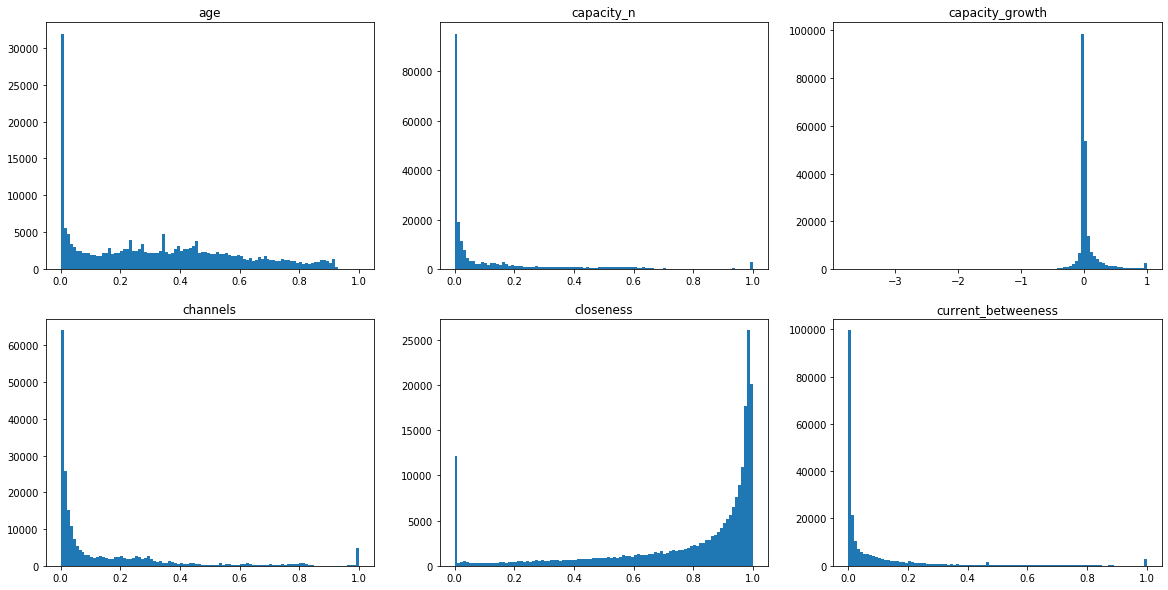

In [8]:
plt.figure(figsize=(20,10))

for i in range(len(features)):
    plt.subplot(2,3, i+1)
    plt.hist(node_feature_df[features[i]], bins = 100)
    plt.title(features[i]);

### Dataframe of Payment Channel Openings

In [19]:
decisions_df_cols = decisions_df.columns

# Extract columns that match feature reg_exp 
open_cols =[col for col in decisions_df_cols if ((not col.startswith('open')) and ('open' in col))]
open_df = full_decisions_df.filter(open_cols)

close_cols =[col for col in decisions_df_cols if ((not col.startswith('close_')) and ('close' in col))]
close_df = full_decisions_df.filter(close_cols)

# Drop missing values
open_df.dropna(inplace=True)
close_df.dropna(inplace=True)

# Engineer Target Variables: average changes in closeness and betweenness for n0 and n1 in the pair-wise channel after channel closing

close_df['diff_closeness'] = np.mean(close_df['closeness_approx_rank_post_n1_close_norm_rankpost'] 
                                - close_df['closeness_approx_rank_n1_close_norm_rank']
                                + close_df['closeness_approx_rank_post_n0_close_norm_rankpost'] 
                                - close_df['closeness_approx_rank_n0_close_norm_rank'])

close_df['diff_betweenness'] = np.mean(close_df['current_betweeness_unweighted_n1_close_norm_rankpost'] 
                                 - close_df['current_betweeness_unweighted_n1_close_norm_rank']
                                + close_df['current_betweeness_unweighted_n0_close_norm_rankpost'] 
                                 - close_df['current_betweeness_unweighted_n0_close_norm_rank'])

In [20]:
# Create simplified DataFrame with open decision data
open_cols = ['short_channel_id','open_block','node0_id', 'node1_id', 'satoshis', 'open_fee',
                'age_n0_open_norm_rank','age_n1_open_norm_rank',
                'capacity_n0_open_norm_rank', 'capacity_n1_open_norm_rank',
                'capacity_growth_n0_open_norm_rank','capacity_growth_n1_open_norm_rank',
                'channels_n0_open_norm_rank','channels_n1_open_norm_rank', 
        'closeness_approx_rank_n0_open_norm_rank',
       'closeness_approx_rank_n1_open_norm_rank',
       'closeness_approx_rank_post_n0_open_norm_rankpost',
       'closeness_approx_rank_post_n1_open_norm_rankpost',
       'current_betweeness_unweighted_n0_open_norm_rank',
       'current_betweeness_unweighted_n1_open_norm_rank',
       'current_betweeness_unweighted_n0_open_norm_rankpost',
       'current_betweeness_unweighted_n1_open_norm_rankpost']
open_df = full_decisions_df.filter(open_cols)

In [33]:
close_cols = ['short_channel_id','close_block','node0_id', 'node1_id', 'satoshis', 'close_fee',
                'age_n0_close_norm_rank','age_n1_close_norm_rank',
                'capacity_n0_close_norm_rank', 'capacity_n1_close_norm_rank',
                'capacity_growth_n0_close_norm_rank','capacity_growth_n1_close_norm_rank',
                'channels_n0_close_norm_rank','channels_n1_close_norm_rank', 
        'closeness_approx_rank_n0_close_norm_rank',
       'closeness_approx_rank_n1_close_norm_rank',
       'closeness_approx_rank_post_n0_close_norm_rankpost',
       'closeness_approx_rank_post_n1_close_norm_rankpost',
       'current_betweeness_unweighted_n0_close_norm_rank',
       'current_betweeness_unweighted_n1_close_norm_rank',
       'current_betweeness_unweighted_n0_close_norm_rankpost',
       'current_betweeness_unweighted_n1_close_norm_rankpost']
close = close_df.filter(close_cols)
close.dropna(inplace = True)

,short_channel_id,close_block,node0_id,node1_id,satoshis,close_fee,age_n0_close_norm_rank,age_n1_close_norm_rank,capacity_n0_close_norm_rank,capacity_n1_close_norm_rank,...,channels_n0_close_norm_rank,channels_n1_close_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank,closeness_approx_rank_post_n0_close_norm_rankpost,closeness_approx_rank_post_n1_close_norm_rankpost,current_betweeness_unweighted_n0_close_norm_rank,current_betweeness_unweighted_n1_close_norm_rank,current_betweeness_unweighted_n0_close_norm_rankpost,current_betweeness_unweighted_n1_close_norm_rankpost
278,617118x511x1,617245.0,1392,5286,11000000,5127.0,0.596904,0.002462,0.364293,0.007223,...,0.251779,0.000890,0.982420,0.300888,0.982408,0.000000,0.118411,0.000000,0.110492,0.000000
347,617078x1074x1,617186.0,994,6065,20000,4897.0,0.002419,0.549279,0.000081,0.179109,...,0.009795,0.087266,0.802935,0.977850,0.586825,0.977083,0.007099,0.030621,0.002131,0.018994
348,617078x1073x0,617186.0,994,7088,20000,4897.0,0.002419,0.894909,0.000081,0.003813,...,0.009795,0.006233,0.802935,0.788087,0.586825,0.782270,0.007099,0.002447,0.002131,0.000491
349,617078x1072x0,617186.0,994,4249,20000,4897.0,0.002419,0.757051,0.000081,0.192646,...,0.009795,0.540516,0.802935,0.994270,0.586825,0.994074,0.007099,0.269928,0.002131,0.299679
350,617078x1071x0,617187.0,5864,994,20000,4897.0,0.521703,0.002428,0.007071,0.000053,...,0.043633,0.004452,0.901865,0.531963,0.906642,0.560722,0.006683,0.002131,0.011048,0.002302


In [82]:
# Engineer Target Variables: average changes in closeness and betweenness for n0 and n1 in the pair-wise channel after channel closing

close['closey_closeness'] = 0.5 * (close['closeness_approx_rank_post_n1_close_norm_rankpost'] 
                                - close['closeness_approx_rank_n1_close_norm_rank']
                                + close['closeness_approx_rank_post_n0_close_norm_rankpost'] 
                                - close['closeness_approx_rank_n0_close_norm_rank'])

close['closey_betweenness'] = 0.5 * (close['current_betweeness_unweighted_n1_close_norm_rankpost'] 
                                 - close['current_betweeness_unweighted_n1_close_norm_rank']
                                + close['current_betweeness_unweighted_n0_close_norm_rankpost'] 
                                 - close['current_betweeness_unweighted_n0_close_norm_rank'])

In [37]:
closeX_cols = ['age_n0_close_norm_rank','age_n1_close_norm_rank',
        'capacity_n0_close_norm_rank', 'capacity_n1_close_norm_rank',
        'capacity_growth_n0_close_norm_rank','capacity_growth_n1_close_norm_rank',
        'channels_n0_close_norm_rank','channels_n1_close_norm_rank']
closeX = close.filter(closeX_cols)


In [43]:
closeX['age_diff_close'] = np.abs(closeX['age_n0_close_norm_rank'] - closeX['age_n1_close_norm_rank'])
closeX['channel_diff_close'] = np.abs(closeX['channels_n0_close_norm_rank'] - closeX['channels_n1_close_norm_rank'])
closeX['capacity_diff_close'] = np.abs(closeX['capacity_n0_close_norm_rank'] - closeX['capacity_n1_close_norm_rank'])
closeX['growth_diff_close'] = np.abs(closeX['capacity_growth_n0_close_norm_rank'] - closeX['capacity_growth_n1_close_norm_rank'])

closeX['age_avg_close'] = np.mean(closeX[['age_n0_close_norm_rank','age_n1_close_norm_rank']],axis =1)
closeX['channel_avg_close'] = np.mean(closeX[['channels_n0_close_norm_rank','channels_n1_close_norm_rank']],axis=1)
closeX['capacity_avg_close'] = np.mean(closeX[['capacity_n0_close_norm_rank','capacity_n1_close_norm_rank']], axis=1)
closeX['growth_avg_close'] = np.mean(closeX[['capacity_growth_n0_close_norm_rank','capacity_growth_n1_close_norm_rank']], axis=1)


In [45]:
avg_diff_close_cols = ['age_diff_close','channel_diff_close','capacity_diff_close','growth_diff_close',
            'age_avg_close','channel_avg_close','capacity_avg_close', 'growth_avg_close']

# Create avg_diff dataframe
close_avg_diff = closeX.filter(avg_diff_close_cols)

In [71]:
kmeans = KMeans(n_clusters= 3, random_state = 123)
kmeans.fit(close_avg_diff)
y_kmeans = kmeans.predict(close_avg_diff)
print(kmeans.inertia_)
close_avg_diff['close_block_cluster_label'] = y_kmeans

7698.912252548322


In [59]:
formula_closeness_close = "y_closeness ~ C(close_block_cluster_label) -1"
ols_closeness_close = smf.ols(formula_closeness_close, data= close_cluster_df, missing='drop').fit()
print(ols_closeness_close.summary())

                            OLS Regression Results                            
Dep. Variable:            y_closeness   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     265.4
Date:                Sat, 16 May 2020   Prob (F-statistic):          3.34e-115
Time:                        00:58:39   Log-Likelihood:                 19863.
No. Observations:               38346   AIC:                        -3.972e+04
Df Residuals:                   38343   BIC:                        -3.970e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
C(close_bl

In [54]:
formula_betweenness_close = "y_betweenness ~ C(cluster) -1"
ols_betweenness_close = smf.ols(formula_betweenness_close, data= close_cluster_df, missing='drop').fit()
print(ols_betweenness_close.summary())

                            OLS Regression Results                            
Dep. Variable:          y_betweenness   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     683.6
Date:                Sat, 16 May 2020   Prob (F-statistic):          2.00e-292
Time:                        00:39:14   Log-Likelihood:                 46105.
No. Observations:               38346   AIC:                        -9.220e+04
Df Residuals:                   38343   BIC:                        -9.218e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
C(cluster)[0]    -0.0072      0.000    -14.609

In [23]:
# Engineer Target Variables: average changes in closeness and betweenness for n0 and n1 in the pair-wise channel after channel opening

open_df['y_closeness'] = 0.5 * (open_df['closeness_approx_rank_post_n1_open_norm_rankpost'] 
                                - open_df['closeness_approx_rank_n1_open_norm_rank']
                                + open_df['closeness_approx_rank_post_n0_open_norm_rankpost'] 
                                - open_df['closeness_approx_rank_n0_open_norm_rank'])

open_df['y_betweeness'] = 0.5 * (open_df['current_betweeness_unweighted_n1_open_norm_rankpost'] 
                                 - open_df['current_betweeness_unweighted_n1_open_norm_rank']
                                + open_df['current_betweeness_unweighted_n0_open_norm_rankpost'] 
                                 - open_df['current_betweeness_unweighted_n0_open_norm_rank'])

In [24]:
# Keep only the columns needed to calculate averages and differences between node0 and node1
x_cols = ['age_n0_open_norm_rank','age_n1_open_norm_rank',
        'capacity_n0_open_norm_rank', 'capacity_n1_open_norm_rank',
        'capacity_growth_n0_open_norm_rank','capacity_growth_n1_open_norm_rank',
        'channels_n0_open_norm_rank','channels_n1_open_norm_rank']
X = open_df.filter(x_cols)

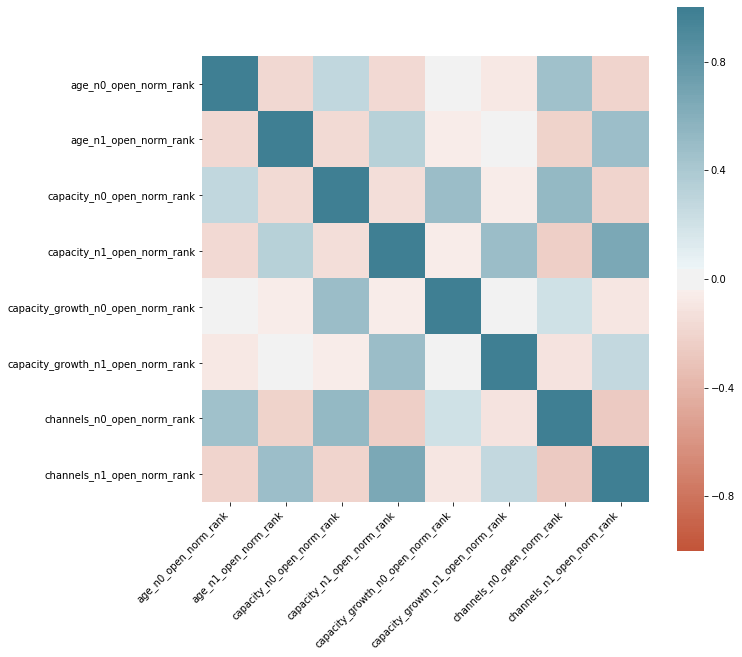

In [26]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [27]:
X['age_diff_open'] = np.abs(X['age_n0_open_norm_rank'] - X['age_n1_open_norm_rank'])
X['channel_diff_open'] = np.abs(X['channels_n0_open_norm_rank'] - X['channels_n1_open_norm_rank'])
X['capacity_diff_open'] = np.abs(X['capacity_n0_open_norm_rank'] - X['capacity_n1_open_norm_rank'])
X['growth_diff_open'] = np.abs(X['capacity_growth_n0_open_norm_rank'] - X['capacity_growth_n1_open_norm_rank'])

X['age_avg_open'] = np.mean(X[['age_n0_open_norm_rank','age_n1_open_norm_rank']],axis =1)
X['channel_avg_open'] = np.mean(X[['channels_n0_open_norm_rank','channels_n1_open_norm_rank']],axis=1)
X['capacity_avg_open'] = np.mean(X[['capacity_n0_open_norm_rank','capacity_n1_open_norm_rank']], axis=1)
X['growth_avg_open'] = np.mean(X[['capacity_growth_n0_open_norm_rank','capacity_growth_n1_open_norm_rank']], axis=1)

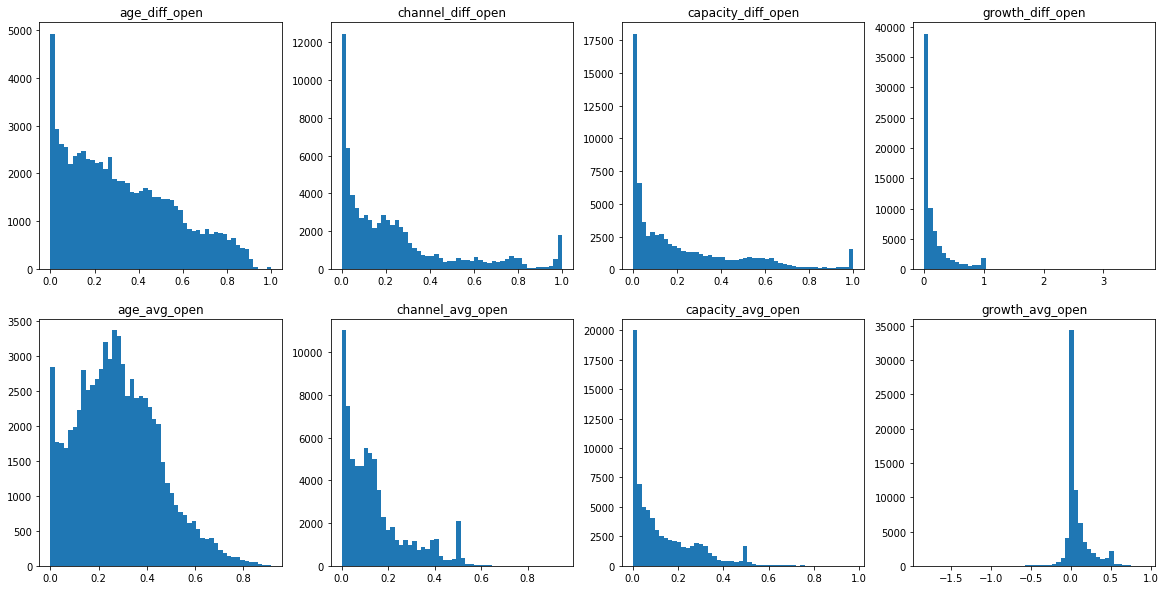

In [74]:
avg_diff_columns = ['age_diff_open','channel_diff_open','capacity_diff_open','growth_diff_open',
            'age_avg_open','channel_avg_open','capacity_avg_open', 'growth_avg_open']

# Create avg_diff dataframe
avg_diff_df = X.filter(avg_diff_columns)

# Plot a histogram of each feature
plt.figure(figsize=(20,10))
for i in range(8):
    plt.subplot(2,4, i+1)
    plt.hist(X[avg_diff_columns[i]], bins = 50)
    plt.title(avg_diff_columns[i]);

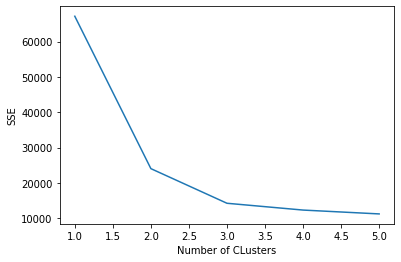

In [66]:
# Cluster on avg_diff_df
# avg_diff_train = avg_diff_df.iloc[train_idx]
# avg_diff_test = avg_diff_df.iloc[test_idx]

from sklearn.cluster import KMeans

n_clusters = np.arange(1, 6)
sse = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(avg_diff_df)
    sse.append(kmeans.inertia_)

plt.plot(n_clusters, sse)
plt.xlabel('Number of CLusters')
plt.ylabel('SSE');

### K-means Clustering

In [9]:
train_idx = np.random.choice(range(len(X)), int(len(X) * .8), replace=False)
test_idx = list(set(range(len(X))) - set(list(train_idx))) 
# What is iloc again? how is it different from without it?

In [79]:
kmeans = KMeans(n_clusters= 3, random_state = 123)
kmeans.fit(avg_diff_df)
y_kmeans = kmeans.predict(avg_diff_df)
print(kmeans.inertia_)
avg_diff_df['cluster'] = y_kmeans
avg_diff_df.head(5)

14246.100692266866


,age_diff_open,channel_diff_open,capacity_diff_open,growth_diff_open,age_avg_open,channel_avg_open,capacity_avg_open,growth_avg_open,cluster
0,0.625429,0.141844,0.100407,0.661589,0.349434,0.101950,0.055807,0.330545,1
10,0.569681,0.220745,0.059594,0.003272,0.288184,0.117465,0.029856,0.002084,0
11,0.754697,0.127660,0.085104,0.006414,0.377358,0.065603,0.042583,-0.002973,0
12,0.380795,0.014184,0.005139,0.000920,0.190398,0.007092,0.002569,0.000460,0
13,0.896226,0.734929,0.999984,0.224337,0.448345,0.368351,0.500008,0.112292,2


In [83]:
close_cluster_label_df = avg_diff_df.filter(['cluster']).join(close.filter(['closey_closeness','closey_betweenness']))

In [86]:
close_cluster_label_df.head()

,cluster,closey_closeness,closey_betweenness
0,1,NaN,NaN
10,0,NaN,NaN
11,0,NaN,NaN
12,0,NaN,NaN
13,2,NaN,NaN


In [ ]:
close_cluster_label_df.dropna(inplace= True)

In [91]:
close_cluster_label_df = close_cluster_label_df.rename(columns={"cluster": "close_block_cluster_label"}).dropna()

In [94]:
formula_closeness_close = "closey_closeness ~ C(close_block_cluster_label) -1"
ols_closeness_close = smf.ols(formula_closeness_close, data= close_cluster_label_df, missing='drop').fit()
print(ols_closeness_close.summary())

                            OLS Regression Results                            
Dep. Variable:       closey_closeness   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     125.3
Date:                Sat, 16 May 2020   Prob (F-statistic):           5.69e-55
Time:                        12:33:27   Log-Likelihood:                 19721.
No. Observations:               38341   AIC:                        -3.944e+04
Df Residuals:                   38338   BIC:                        -3.941e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
C(close_bl

In [95]:
formula_betweenness_close = "closey_betweenness ~ C(close_block_cluster_label) -1"
ols_betweenness_close = smf.ols(formula_betweenness_close, data= close_cluster_label_df, missing='drop').fit()
print(ols_betweenness_close.summary())

                            OLS Regression Results                            
Dep. Variable:     closey_betweenness   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     229.0
Date:                Sat, 16 May 2020   Prob (F-statistic):           1.39e-99
Time:                        12:35:12   Log-Likelihood:                 45652.
No. Observations:               38341   AIC:                        -9.130e+04
Df Residuals:                   38338   BIC:                        -9.127e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
C(close_bl

In [68]:
cluster_df = avg_diff_df.filter(['cluster']).join(open_df.filter(['y_closeness','y_betweeness']))

In [69]:
cluster_df.head()

,cluster,y_closeness,y_betweeness
0,2,0.013187,-0.006441
10,0,0.013955,0.015305
11,0,0.080362,0.034225
12,0,0.078463,0.003666
13,1,-0.040312,-0.221043


In [177]:
formula_closeness = "y_closeness ~ C(cluster) -1"
ols_closeness = smf.ols(formula_closeness, data= cluster_df, missing='drop').fit()
print(ols_closeness.summary())

                            OLS Regression Results                            
Dep. Variable:            y_closeness   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     1749.
Date:                Tue, 12 May 2020   Prob (F-statistic):               0.00
Time:                        00:17:49   Log-Likelihood:                 77151.
No. Observations:               72445   AIC:                        -1.543e+05
Df Residuals:                   72442   BIC:                        -1.543e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
C(cluster)[0]     0.0364      0.000     95.322

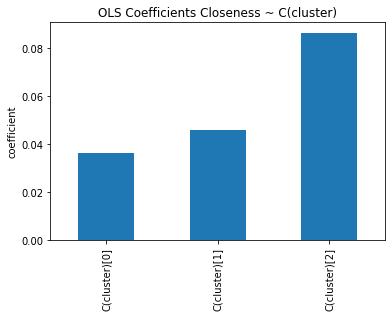

In [187]:
ols_closeness.params.plot.bar()
plt.ylabel('coefficient')
plt.title('OLS Coefficients Closeness ~ C(cluster)');

In [185]:
formula_betweenness = "y_betweeness ~ C(cluster) -1"
ols_betweenness = smf.ols(formula_betweenness, data= cluster_df, missing='drop').fit()
print(ols_betweenness.summary())

                            OLS Regression Results                            
Dep. Variable:           y_betweeness   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.880
Date:                Tue, 12 May 2020   Prob (F-statistic):             0.0207
Time:                        00:23:38   Log-Likelihood:                 85970.
No. Observations:               72445   AIC:                        -1.719e+05
Df Residuals:                   72442   BIC:                        -1.719e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
C(cluster)[0]     0.0019      0.000      5.580

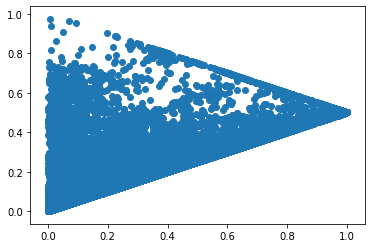

In [175]:
# cap_growth = avg_diff_df.filter(['capacity_diff_open','capacity_avg_open','cluster'])
plt.scatter(avg_diff_df['capacity_diff_open'],avg_diff_df['capacity_avg_open'])

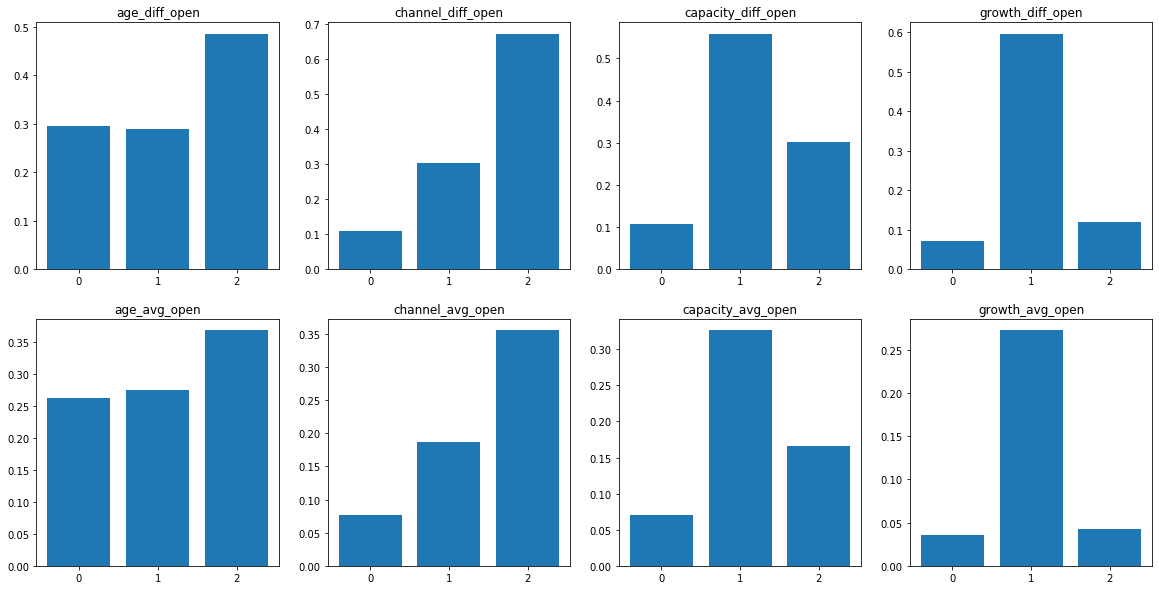

In [173]:
plt.figure(figsize=(20,10))
for i in range(len(avg_diff_columns)):
    plt.subplot(2,4, i+1)
    plt.xticks([0,1,2])
    plt.bar(avg_diff_df.groupby('cluster')[avg_diff_columns[i]].mean().index, avg_diff_df.groupby('cluster')[avg_diff_columns[i]].mean());
    plt.title(avg_diff_columns[i]);

### Network Evolution

In [229]:
network_evolution = avg_diff_df.join(open_df.filter(['open_block']))
stone = network_evolution[(network_evolution['open_block'] >= 515000) & (network_evolution['open_block'] < 521000)]
golden = network_evolution[(network_evolution['open_block'] >= 521000) & (network_evolution['open_block'] < 551000)]
decline = network_evolution[(network_evolution['open_block'] >= 551000) & (network_evolution['open_block'] < 575000)]
dark = network_evolution[network_evolution['open_block'] >= 575000]

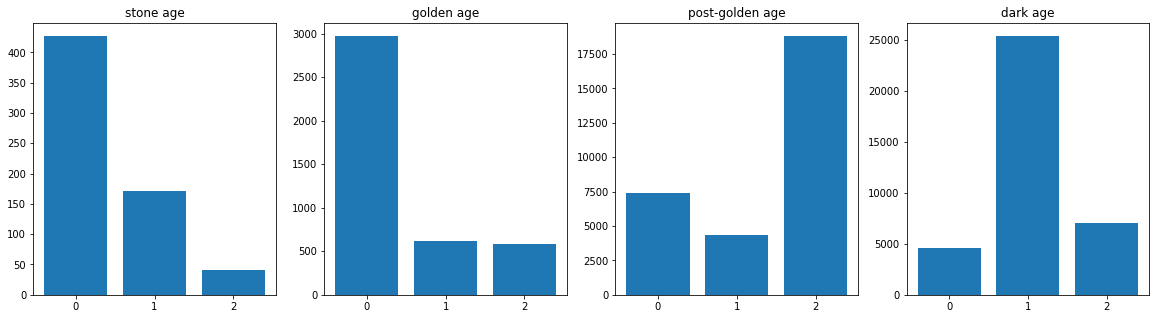

In [231]:
phases = [stone, golden, decline, dark]
phase_names = ["stone", "golden", "post-golden", "dark"]
plt.figure(figsize=(20,5))
for i in range(len(phases)):
    plt.subplot(1,4, i+1)
    plt.xticks([0,1,2])
    plt.bar(phases[i].cluster.unique(),phases[i].groupby('cluster').cluster.count())
    plt.title(phase_names[i]+' age');

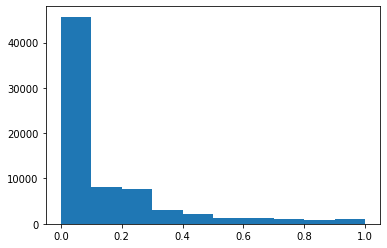

In [163]:
plt.hist(X['channels_n1_open_norm_rank']); # tag each node with label small, intermediate, big

Text(0, 0.5, 'SSE')

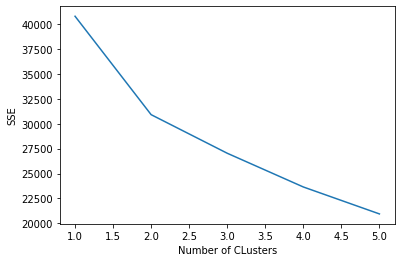

In [12]:
n_clusters = np.arange(1, 6)
sse = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)

plt.plot(n_clusters, sse)
plt.xlabel('Number of CLusters')
plt.ylabel('SSE')

In [14]:
from sklearn import decomposition
from sklearn.decomposition import PCA

pca = decomposition.PCA(n_components = 3)
train_pca = pca.fit_transform(X_train)
print("The amount of variance explained by the projected data is {}%".format(np.sum(pca.explained_variance_ratio_)))
print("Dimension of original data {}".format(X_train.shape))
print("Dimension of projected data reprentation {}".format(train_pca.shape))

The amount of variance explained by the projected data is 0.6470429052883233%
Dimension of original data (57963, 12)
Dimension of projected data reprentation (57963, 3)


In [45]:
pca.components_

array([[-0.29340756,  0.31864694, -0.20856982,  0.26651066, -0.19945029,
         0.31612794, -0.08581338,  0.1606631 , -0.28985506,  0.29797445,
        -0.39656525,  0.44145696],
       [ 0.33371817,  0.25219054,  0.21332228,  0.20669727,  0.23880737,
         0.27414541,  0.13668311,  0.17408881,  0.26940883,  0.21145373,
         0.5281839 ,  0.39919429],
       [ 0.00975327,  0.4603444 , -0.07174877, -0.27804352, -0.05686137,
        -0.40507395, -0.04314198, -0.55988898, -0.04994674, -0.15272749,
         0.10392478,  0.43157395]])

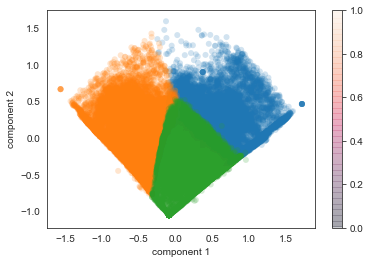

In [33]:
# Plot the clusters from the perspectives of the first two principal components in a 2d graph
for i in np.unique(kmeans.labels_):
    plt.scatter(train_pca[kmeans.labels_ == i, 0], train_pca[kmeans.labels_ == i, 1], edgecolor='none', alpha=0.2, 
                cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

<Figure size 480x480 with 0 Axes>

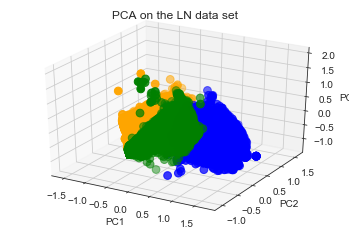

In [37]:
# Plot the clusters from the perspectives of the first three principal components in 3d graph
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("white")
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Plot initialisation
colors = ['blue','orange','green']
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(kmeans.labels_):
    ax.scatter(train_pca[kmeans.labels_ == i, 0], train_pca[kmeans.labels_ == i, 1], train_pca[kmeans.labels_ == i, 2],
               c=colors[i], cmap="Set2_r", s=60)

# make simple, bare axis lines through space:
# xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
# ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
# yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
# ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
# zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
# ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the LN data set")
plt.show();


### Dataframe of Channels that are Closed

In [31]:
close_df = full_decisions_df[full_decisions_df['close_block'].notnull()]
print('How many closes: ',len(close_df))
close_df.head()

How many closes:  38355


,Unnamed: 0.1,short_channel_id,open_block,open_transaction,address,close_block,close_transaction,node0,node1,satoshis,...,closeness_approx_rank_post_n0_close_norm_rankpost,closeness_approx_rank_post_n1_close_norm_rankpost,current_betweeness_unweighted_n0_open_norm_rank,current_betweeness_unweighted_n1_open_norm_rank,current_betweeness_unweighted_n0_close_norm_rank,current_betweeness_unweighted_n1_close_norm_rank,current_betweeness_unweighted_n0_open_norm_rankpost,current_betweeness_unweighted_n1_open_norm_rankpost,current_betweeness_unweighted_n0_close_norm_rankpost,current_betweeness_unweighted_n1_close_norm_rankpost
278,72178,617118x511x1,617118,2a18821070d2e46d20e1d94b3dfa2dae894ec78755749f...,bc1q5czf4zz7ut8acvx8dm6q8ffse8yqq7tv86n09pt6xe...,617245.0,26faabb331ef297008d7684e09b8ba530be41457a9488b...,039edc94987c8f3adc28dab455efc00dea876089a120f5...,03b27c85b6359c5c688a900f6cc271cb47945d76e1c391...,11000000,...,0.982408,0.000000,0.092769,0.000000,0.118411,0.000000,0.092556,0.000000,0.110492,0.000000
347,72112,617078x1074x1,617078,aa58b7004d09169797cf1d22d777bf9c360038a5203de3...,bc1q2pjwaq6wzuwrdgsk2s2t27vn56xgx9neczukz2au5g...,617186.0,e2578e1c85904ca2324d238f1da0df3e700adfc5e1fb09...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,02c12b5459cf107ee0440cae41902f1189db50fa003a07...,20000,...,0.586825,0.977083,0.002701,0.024509,0.007099,0.030621,0.005966,0.017218,0.002131,0.018994
348,72111,617078x1073x0,617078,e8510183e69482b8787fbc8a9849b4799dbb77f1a735ec...,bc1qdmyfvtzlqnyjvczusx3tv9332t9rf5k6axl56yff65...,617186.0,c87ace7dde238ffb13158b37fa25ff5da7602268cd2f03...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,030043d0a2cfb69d80867094eb030f8abde7a5dc36e1a0...,20000,...,0.586825,0.782270,0.002701,0.001618,0.007099,0.002447,0.005966,0.002039,0.002131,0.000491
349,72110,617078x1072x0,617078,81b09c2cd9596a61863533e7cdeac76141a63c445965e8...,bc1qn9e0tghjs7aj9mkferducy0zvezykmvu28pdp0glu6...,617186.0,a58998f8096668624e6c2317c4274f8f73916f6142d6d5...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e...,20000,...,0.586825,0.994074,0.002701,0.238078,0.007099,0.269928,0.005966,0.404949,0.002131,0.299679
350,72109,617078x1071x0,617078,a5e42f74802d63ba6d57ce0f7a5edeba76e5f21a990557...,bc1qg7pu3y76lducfxtpxtff84suwhk20v5luhxsed97m6...,617187.0,e555009d6b51e50318da6801d4e8788d4b956991a49659...,021802799027508e8a8bf9a0ab96ea78a6a995926a0b13...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,20000,...,0.906642,0.560722,0.014259,0.002701,0.006683,0.002131,0.015528,0.005966,0.011048,0.002302


In [129]:
close_columns = ['short_channel_id','open_block','close_block','node0_id', 'node1_id', 'satoshis', 'open_fee','age_n0_open_norm_rank',
       'age_n1_open_norm_rank', 'betweeness_curr_aprox_n0_open_norm_rank','betweeness_curr_aprox_n1_open_norm_rank',
       'capacity_n0_open_norm_rank', 'capacity_n1_open_norm_rank','capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank','channels_n0_open_norm_rank','channels_n1_open_norm_rank', 
       'closeness_approx_rank_n0_open_norm_rank','closeness_approx_rank_n1_open_norm_rank', 'age_n0_close_norm_rank',
       'age_n1_close_norm_rank', 'betweeness_curr_aprox_n0_close_norm_rank','betweeness_curr_aprox_n1_close_norm_rank',
       'capacity_n0_close_norm_rank', 'capacity_n1_close_norm_rank','capacity_growth_n0_close_norm_rank',
       'capacity_growth_n1_close_norm_rank','channels_n0_close_norm_rank','channels_n1_close_norm_rank', 
       'closeness_approx_rank_n0_close_norm_rank','closeness_approx_rank_n1_close_norm_rank']
close_df = close_df.filter(close_columns)
close_df.head()

,short_channel_id,open_block,close_block,node0_id,node1_id,satoshis,open_fee,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,...,betweeness_curr_aprox_n0_close_norm_rank,betweeness_curr_aprox_n1_close_norm_rank,capacity_n0_close_norm_rank,capacity_n1_close_norm_rank,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank
278,617118x511x1,617118,617245.0,1392,5286,11000000,1694,0.596447,0.001331,0.449403,...,0.126052,1.867708e-12,0.364293,0.007223,0.073384,0.057292,0.251779,0.000890,0.982420,0.300888
347,617078x1074x1,617078,617186.0,994,6065,20000,4582,0.001447,0.548840,0.000076,...,0.000133,7.790642e-02,0.000081,0.179109,0.000658,0.114918,0.009795,0.087266,0.802935,0.977850
348,617078x1073x0,617078,617186.0,994,7088,20000,4582,0.001447,0.894806,0.000076,...,0.000133,1.257137e-03,0.000081,0.003813,0.000658,-0.008398,0.009795,0.006233,0.802935,0.788087
349,617078x1072x0,617078,617186.0,994,4249,20000,4582,0.001447,0.756815,0.000076,...,0.000133,2.132576e-01,0.000081,0.192646,0.000658,0.116228,0.009795,0.540516,0.802935,0.994270
350,617078x1071x0,617078,617187.0,5864,994,20000,4581,0.521233,0.001447,0.003057,...,0.003704,4.946882e-05,0.007071,0.000053,0.000261,0.000431,0.043633,0.004452,0.901865,0.531963


In [178]:
close_df['channel_age'] = close_df.close_block.astype('int') - close_df.open_block
close_df.head()

,short_channel_id,open_block,close_block,node0_id,node1_id,satoshis,open_fee,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,...,betweeness_curr_aprox_n1_close_norm_rank,capacity_n0_close_norm_rank,capacity_n1_close_norm_rank,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank,channel_age
278,617118x511x1,617118,617245.0,1392,5286,11000000,1694,0.596447,0.001331,0.449403,...,1.867708e-12,0.364293,0.007223,0.073384,0.057292,0.251779,0.000890,0.982420,0.300888,127
347,617078x1074x1,617078,617186.0,994,6065,20000,4582,0.001447,0.548840,0.000076,...,7.790642e-02,0.000081,0.179109,0.000658,0.114918,0.009795,0.087266,0.802935,0.977850,108
348,617078x1073x0,617078,617186.0,994,7088,20000,4582,0.001447,0.894806,0.000076,...,1.257137e-03,0.000081,0.003813,0.000658,-0.008398,0.009795,0.006233,0.802935,0.788087,108
349,617078x1072x0,617078,617186.0,994,4249,20000,4582,0.001447,0.756815,0.000076,...,2.132576e-01,0.000081,0.192646,0.000658,0.116228,0.009795,0.540516,0.802935,0.994270,108
350,617078x1071x0,617078,617187.0,5864,994,20000,4581,0.521233,0.001447,0.003057,...,4.946882e-05,0.007071,0.000053,0.000261,0.000431,0.043633,0.004452,0.901865,0.531963,109


In [180]:
close_df.dropna(inplace=True)

Text(0.5, 1.0, 'distribution of channel age')

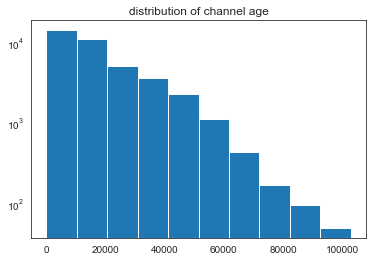

In [294]:
plt.hist(close_df.channel_age)
plt.yscale('log')
plt.title('distribution of channel age')

In [135]:
Xy_close = close_df.drop(labels =['short_channel_id','open_block','close_block','node0_id', 'node1_id', 'satoshis', 'open_fee'], axis =1)

Xy_close.corr()

,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,betweeness_curr_aprox_n1_open_norm_rank,capacity_n0_open_norm_rank,capacity_n1_open_norm_rank,capacity_growth_n0_open_norm_rank,capacity_growth_n1_open_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,...,betweeness_curr_aprox_n1_close_norm_rank,capacity_n0_close_norm_rank,capacity_n1_close_norm_rank,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank,channel_age
age_n0_open_norm_rank,1.000000,-0.209950,0.401833,-0.167916,0.277335,-0.147721,-0.019630,-0.062170,0.404584,-0.196229,...,-0.162728,0.231855,-0.141710,-0.010127,0.037650,0.317468,-0.187858,0.370289,-0.134974,-0.046359
age_n1_open_norm_rank,-0.209950,1.000000,-0.180816,0.404623,-0.148500,0.321524,-0.043540,0.030609,-0.217080,0.464913,...,0.389272,-0.144612,0.317517,0.037595,-0.005321,-0.214365,0.405000,-0.129273,0.414472,-0.074623
betweeness_curr_aprox_n0_open_norm_rank,0.401833,-0.180816,1.000000,-0.174077,0.714455,-0.194169,0.326117,-0.103520,0.732100,-0.210911,...,-0.175931,0.635880,-0.195056,-0.038283,0.024712,0.668606,-0.214496,0.340704,-0.120613,0.076142
betweeness_curr_aprox_n1_open_norm_rank,-0.167916,0.404623,-0.174077,1.000000,-0.180009,0.774693,-0.084323,0.397788,-0.219569,0.803043,...,0.772988,-0.176719,0.679672,0.029052,-0.064820,-0.223886,0.718326,-0.121080,0.351495,0.039914
capacity_n0_open_norm_rank,0.277335,-0.148500,0.714455,-0.180009,1.000000,-0.187067,0.516316,-0.096452,0.492303,-0.221086,...,-0.175258,0.894376,-0.187001,-0.064742,0.022005,0.459443,-0.219808,0.373834,-0.106225,-0.031726
capacity_n1_open_norm_rank,-0.147721,0.321524,-0.194169,0.774693,-0.187067,1.000000,-0.084387,0.543213,-0.245670,0.638874,...,0.712584,-0.185198,0.884256,0.031390,-0.083353,-0.247985,0.584289,-0.123420,0.407123,-0.056104
capacity_growth_n0_open_norm_rank,-0.019630,-0.043540,0.326117,-0.084323,0.516316,-0.084387,1.000000,-0.017067,0.200371,-0.106704,...,-0.077847,0.527656,-0.088395,0.112012,-0.040490,0.221495,-0.106858,0.220323,-0.003621,0.083840
capacity_growth_n1_open_norm_rank,-0.062170,0.030609,-0.103520,0.397788,-0.096452,0.543213,-0.017067,1.000000,-0.129811,0.291948,...,0.376350,-0.091072,0.514156,0.007303,0.067572,-0.133030,0.306207,-0.032095,0.233376,0.108878
channels_n0_open_norm_rank,0.404584,-0.217080,0.732100,-0.219569,0.492303,-0.245670,0.200371,-0.129811,1.000000,-0.257910,...,-0.221316,0.470871,-0.245707,-0.052740,0.036167,0.909806,-0.264368,0.406041,-0.140635,0.044962
channels_n1_open_norm_rank,-0.196229,0.464913,-0.210911,0.803043,-0.221086,0.638874,-0.106704,0.291948,-0.257910,1.000000,...,0.726062,-0.219274,0.586355,0.027636,-0.063937,-0.264286,0.905376,-0.135521,0.419896,0.035691


In [182]:
# split into train, test
close_X = close_df.drop(labels =['short_channel_id','open_block','close_block','node0_id', 'node1_id', 'satoshis', 'open_fee', 'channel_age'], axis =1)
close_y = close_df['channel_age']


In [156]:
close_X.columns

Index(['age_n0_open_norm_rank', 'age_n1_open_norm_rank',
       'betweeness_curr_aprox_n0_open_norm_rank',
       'betweeness_curr_aprox_n1_open_norm_rank', 'capacity_n0_open_norm_rank',
       'capacity_n1_open_norm_rank', 'capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank', 'channels_n0_open_norm_rank',
       'channels_n1_open_norm_rank', 'closeness_approx_rank_n0_open_norm_rank',
       'closeness_approx_rank_n1_open_norm_rank', 'age_n0_close_norm_rank',
       'age_n1_close_norm_rank', 'betweeness_curr_aprox_n0_close_norm_rank',
       'betweeness_curr_aprox_n1_close_norm_rank',
       'capacity_n0_close_norm_rank', 'capacity_n1_close_norm_rank',
       'capacity_growth_n0_close_norm_rank',
       'capacity_growth_n1_close_norm_rank', 'channels_n0_close_norm_rank',
       'channels_n1_close_norm_rank',
       'closeness_approx_rank_n0_close_norm_rank',
       'closeness_approx_rank_n1_close_norm_rank'],
      dtype='object')

In [271]:
# close_X['age_diff_close'] = np.abs(close_X['age_n0_close_norm_rank'] - close_X['age_n1_close_norm_rank'])
close_X['channel_diff_close'] = np.abs(close_X['channels_n0_close_norm_rank'] - close_X['channels_n1_close_norm_rank'])
close_X['bet_diff_close'] = np.abs(close_X['betweeness_curr_aprox_n0_close_norm_rank'] - close_X['betweeness_curr_aprox_n1_close_norm_rank'])
close_X['closeness_diff_close'] = np.abs(close_X['closeness_approx_rank_n0_close_norm_rank'] - close_X['closeness_approx_rank_n1_close_norm_rank'])
close_X['capacity_diff_close'] = np.abs(close_X['capacity_n0_close_norm_rank'] - close_X['capacity_n1_close_norm_rank'])
close_X['growth_diff_close'] = np.abs(close_X['capacity_growth_n0_close_norm_rank'] - close_X['capacity_growth_n1_close_norm_rank'])

# close_X['age_avg_close'] = np.mean(close_X['age_n0_close_norm_rank'] + close_X['age_n1_close_norm_rank'])
close_X['channel_avg_close'] = np.mean(close_X[['channels_n0_close_norm_rank','channels_n1_close_norm_rank']], axis=1)
close_X['bet_avg_close'] = np.mean(close_X[['betweeness_curr_aprox_n0_close_norm_rank','betweeness_curr_aprox_n1_close_norm_rank']], axis=1)
close_X['closeness_avg_close'] = np.mean(close_X[['closeness_approx_rank_n0_close_norm_rank','closeness_approx_rank_n1_close_norm_rank']], axis=1)
close_X['capacity_avg_close'] = np.mean(close_X[['capacity_n0_close_norm_rank','capacity_n1_close_norm_rank']], axis=1)
close_X['growth_avg_close'] = np.mean(close_X[['capacity_growth_n0_close_norm_rank', 'capacity_growth_n1_close_norm_rank']], axis=1)

close_avg_diff_columns = ['channel_diff_close','bet_diff_close', 'closeness_diff_close', 
                      'capacity_diff_close', 'growth_diff_close', 'channel_avg_close',
                      'bet_avg_close', 'closeness_avg_close', 'capacity_avg_close', 'growth_avg_close']

In [274]:
close_avg_diff_X = close_X.filter(close_avg_diff_columns)

,channel_diff_close,bet_diff_close,closeness_diff_close,capacity_diff_close,growth_diff_close,channel_avg_close,bet_avg_close,closeness_avg_close,capacity_avg_close,growth_avg_close
278,0.250890,0.126052,0.681531,0.357069,0.016091,0.126335,0.063026,0.641654,0.185758,0.065338
347,0.077471,0.077773,0.174914,0.179028,0.114259,0.048531,0.039020,0.890393,0.089595,0.057788
348,0.003562,0.001124,0.014849,0.003732,0.009056,0.008014,0.000695,0.795511,0.001947,-0.003870
349,0.530721,0.213125,0.191335,0.192566,0.115570,0.275156,0.106695,0.898603,0.096364,0.058443
350,0.039181,0.003655,0.369903,0.007018,0.000170,0.024043,0.001877,0.716914,0.003562,0.000346


In [164]:
avg_diff_df.columns

Index(['age_avg_open', 'channel_avg_open', 'bet_avg_open',
       'closeness_avg_open', 'capacity_avg_open', 'growth_avg_open',
       'age_diff_open', 'channel_diff_open', 'bet_diff_open',
       'closeness_diff_open', 'capacity_diff_open', 'growth_diff_open'],
      dtype='object')

In [275]:
close_avg_diff_X = close_avg_diff_X.join(avg_diff_df).drop(labels =['age_avg_open','age_diff_open'], axis=1)
close_avg_diff_X.head()

,channel_diff_close,bet_diff_close,closeness_diff_close,capacity_diff_close,growth_diff_close,channel_avg_close,bet_avg_close,closeness_avg_close,capacity_avg_close,growth_avg_close,channel_avg_open,bet_avg_open,closeness_avg_open,capacity_avg_open,growth_avg_open,channel_diff_open,bet_diff_open,closeness_diff_open,capacity_diff_open,growth_diff_open
278,0.250890,0.126052,0.681531,0.357069,0.016091,0.126335,0.063026,0.641654,0.185758,0.065338,0.125778,0.224701,0.724769,0.182242,0.044092,0.249778,0.449403,0.532415,0.353668,0.004669
347,0.077471,0.077773,0.174914,0.179028,0.114259,0.048531,0.039020,0.890393,0.089595,0.057788,0.047513,0.032525,0.896081,0.089497,0.048385,0.079041,0.064899,0.150960,0.178826,0.095652
348,0.003562,0.001124,0.014849,0.003732,0.009056,0.008014,0.000695,0.795511,0.001947,-0.003870,0.006661,0.000574,0.781707,0.001943,-0.003148,0.002664,0.000997,0.077787,0.003718,0.007414
349,0.530721,0.213125,0.191335,0.192566,0.115570,0.275156,0.106695,0.898603,0.096364,0.058443,0.273979,0.093014,0.906618,0.096183,0.049272,0.531972,0.185876,0.172034,0.192197,0.097426
350,0.039181,0.003655,0.369903,0.007018,0.000170,0.024043,0.001877,0.716914,0.003562,0.000346,0.025311,0.001566,0.861310,0.003569,0.000375,0.034636,0.002981,0.081419,0.006969,0.000368


### OLS for channel_age (stability)

In [276]:
from sklearn.model_selection import train_test_split
close_trainx, close_testx, close_trainy, close_testy = train_test_split(close_avg_diff_X, close_y, test_size=0.2,random_state=109) 

In [295]:
close_trainx.columns

Index(['channel_diff_close', 'bet_diff_close', 'closeness_diff_close',
       'capacity_diff_close', 'growth_diff_close', 'channel_avg_close',
       'bet_avg_close', 'closeness_avg_close', 'capacity_avg_close',
       'growth_avg_close', 'channel_avg_open', 'bet_avg_open',
       'closeness_avg_open', 'capacity_avg_open', 'growth_avg_open',
       'channel_diff_open', 'bet_diff_open', 'closeness_diff_open',
       'capacity_diff_open', 'growth_diff_open'],
      dtype='object')

In [284]:
OLS_df = close_avg_diff_X.join(close_y)

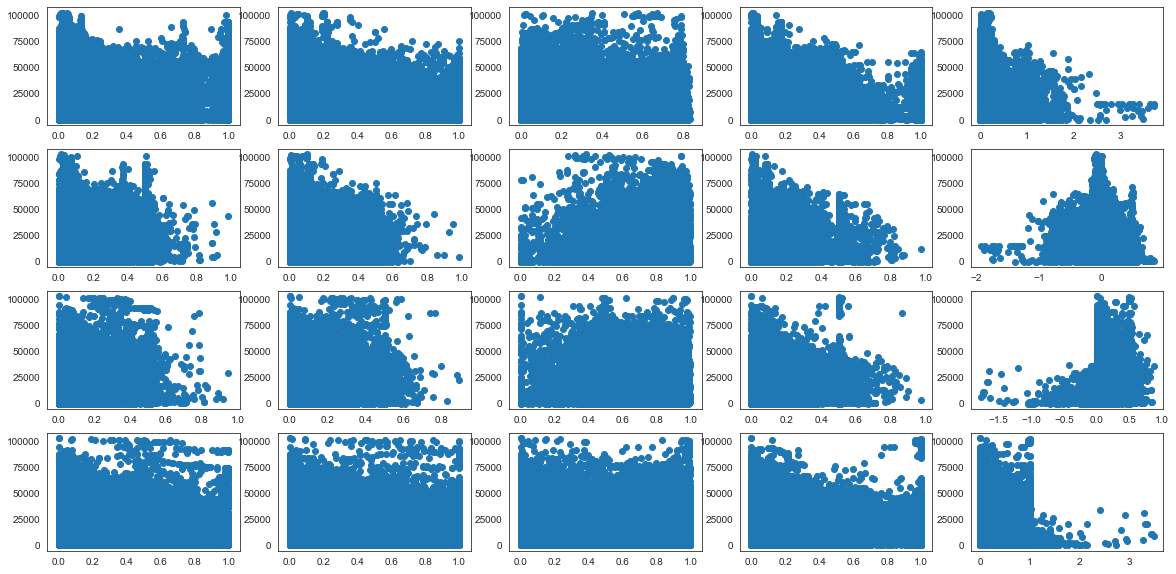

In [290]:
plt.figure(figsize=(20,10))
for i, c in enumerate(close_trainx.columns):
    plt.subplot(4,5,i+1)
    plt.scatter(OLS_df[c], OLS_df.channel_age);

In [302]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(close_trainx, close_trainy)
print('test score is: ',reg.score(close_testx, close_testy))
reg.coef_

test score is:  0.1823877417223705


array([  5452.37024162,    909.20869371,   -372.56239584,  -9236.92198554,
        -8647.29974468,  -8775.61686882,   2709.26771009,  29936.38125409,
       -11620.31239148, -21283.40505813,  64478.32828743,  28292.21339295,
       -25399.13201983, -41412.77898381,  27214.65214175, -35816.42825188,
         2987.05068744,  -1689.32111689,  10749.18387654,   3130.54917942])

In [299]:
formula2 = "channel_age ~  channel_diff_close + bet_diff_close + closeness_diff_close \
+ capacity_diff_close + growth_diff_close + channel_avg_close + bet_avg_close+ closeness_avg_close \
+ capacity_avg_close + growth_avg_close + channel_avg_open + bet_avg_open + closeness_avg_open \
+ capacity_avg_open +  growth_avg_open + channel_diff_open +  bet_diff_open +  closeness_diff_open + \
        capacity_diff_open +  growth_diff_open "
ols2 = smf.ols(formula2, data= OLS_df, missing='drop').fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     434.9
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        15:43:25   Log-Likelihood:            -4.2310e+05
No. Observations:               38344   AIC:                         8.462e+05
Df Residuals:                   38323   BIC:                         8.464e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.391e+04 

In [278]:
formula1 = "channel_age ~ channel_diff_close"
ols1 = smf.ols(formula1, data= OLS_df, missing='drop').fit()
print(ols1.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     58.67
Date:                Fri, 08 May 2020   Prob (F-statistic):           1.91e-14
Time:                        15:20:10   Log-Likelihood:            -4.2699e+05
No. Observations:               38344   AIC:                         8.540e+05
Df Residuals:                   38342   BIC:                         8.540e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.773e+04    116

In [279]:
formula3 = "channel_age ~ channel_avg_close"
ols3 = smf.ols(formula3, data= OLS_df, missing='drop').fit()
print(ols3.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     156.6
Date:                Fri, 08 May 2020   Prob (F-statistic):           7.50e-36
Time:                        15:20:31   Log-Likelihood:            -4.2694e+05
No. Observations:               38344   AIC:                         8.539e+05
Df Residuals:                   38342   BIC:                         8.539e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           1.72e+04    124.08

In [280]:
formula4 = "channel_age ~ channel_avg_close + channel_diff_close + growth_diff_close + growth_avg_close + capacity_diff_close + capacity_avg_close "
ols4 = smf.ols(formula4, data= OLS_df, missing='drop').fit()
print(ols4.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     377.6
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        15:20:54   Log-Likelihood:            -4.2592e+05
No. Observations:               38344   AIC:                         8.519e+05
Df Residuals:                   38337   BIC:                         8.519e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             1.82e+04    

#### Regression using TPOT for channel_age

In [193]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=20, verbosity=1, scoring='r2')  # generations for optimization, pop size is models
tpot.fit(close_trainx, close_trainy.ravel())
print(tpot.score(close_testx, close_testy.ravel()))
# tpot.export('tpot_heart_pipeline.py')
# Can try again on a smaller sample of data with tqdm



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=4, min_samples_split=5, n_estimators=100)
0.5347526073749463


In [195]:
tpot_best = tpot.fitted_pipeline_.steps

tpot_best[-1][1].feature_importances_

array([0.11342011, 0.06777757, 0.06505289, 0.15726155, 0.10202487,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1037416 , 0.09382923, 0.06651351, 0.14031946, 0.09005921])

In [196]:
print(tpot_best[0][1])
tpot_best[0][1].get_feature_names()

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.7500000000000001,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


AttributeError: 'RandomForestRegressor' object has no attribute 'get_feature_names'

In [ ]:
features = x.columns
# features_plot = features
importances = DT2.feature_importances_
idx = np.argsort(importances)
plt.title("Feature importance")
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.ylabel("Feature")
plt.show()